# Homework2:模型優化

說明:以下是一個簡易的使用cnn進行CIFAR-10資料集的實作

* 請基於以下的code完成作業，epoch最多可以調整到15，**若超過扣50分**
* 此作業專注在課堂上提到的優化技巧，請在不調整epoch以外的原本超參數設定的情況下(刪減卷積層數量、神經元數量、batch size等等)完成模型的優化,**若調整扣50分**
* 請使用Data Augmentation、L1 or L2 Regularization、Dropout和Batch Normalization、EarlyStopping的方法來完成
* 可以自行調整L1 or L2 Regularization、Dropout和Batch Normalization的參數
* 請不要刪除文字說明,**違者-10分**
* 若同學的實作方法跟我們提供的順序不一樣的話，請詳細說明在哪個區塊實作，以避免扣分
* 請同學善用markdown或是註解來標示出自己的實作方法，以利批改

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# 使用隨機種子
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(1)  # 固定隨機種子，不可更改

1.Data Augmentation(20分)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()  # 僅轉換為tensor
])


In [ ]:
# 加載 CIFAR-10 原始資料集
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 將訓練集拆分為新的訓練集和驗證集，並固定隨機種子
train_size = int(0.8 * len(trainset_full))  # 80% 作為訓練集
valid_size = len(trainset_full) - train_size  # 20% 作為驗證集
trainset, validset = torch.utils.data.random_split(trainset_full, [train_size, valid_size],
                                                   generator=torch.Generator().manual_seed(1))  # 固定隨機種子，不可更改

# 創建 DataLoader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=100, shuffle=False, num_workers=2)

# 加載 CIFAR-10 測試集並創建 testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# print資料集的大小
print(f"原始訓練集大小: {len(trainset_full)}")
print(f"訓練集大小: {len(trainset)}")
print(f"驗證集大小: {len(validset)}")
print(f"測試集大小: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
原始訓練集大小: 50000
訓練集大小: 40000
驗證集大小: 10000
測試集大小: 10000


2.Dropout、Batch Normalization(40分)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 第一層卷積層
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二層卷積層
        self.pool = nn.MaxPool2d(2, 2)  # 池化層
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 全連接層1
        self.fc2 = nn.Linear(512, 100)  # 全連接層2，對應100類

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 卷積+ReLU+池化
        x = self.pool(F.relu(self.conv2(x)))  # 卷積+ReLU+池化
        x = x.view(-1, 64 * 8 * 8)  # 展平輸入
        x = F.relu(self.fc1(x))  # 全連接層1+ReLU
        x = self.fc2(x)  # 全連接層2 (輸出100類)
        return x


3.L1 or L2 Regularization(20分)

In [ ]:
net = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵損失
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam優化器


4.完成EarlyStopping的設定，若5個EPOCH都沒有更好的結果，就停止訓練
(5分)

5.train_model增加EarlyStopping的判斷邏輯(5分)

In [ ]:


def train_model(epochs):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # 訓練過程
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 記錄訓練集的損失和準確率
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 驗證集評估
        net.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for data in validloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(validloader)
        valid_accuracy = 100 * valid_correct / valid_total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'[Epoch {epoch+1}/{epochs}] Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}% | Validation loss: {valid_loss:.4f}, Validation accuracy: {valid_accuracy:.2f}%')

    print('Finished Training')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [ ]:
def test_model():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the 10000 test images: {100 * correct / total:.2f}%')


In [ ]:
def plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # 損失圖表
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 準確率圖表
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


[Epoch 1/10] Train loss: 1.6528, Train accuracy: 41.62% | Validation loss: 1.3635, Validation accuracy: 49.90%
[Epoch 2/10] Train loss: 1.2158, Train accuracy: 56.66% | Validation loss: 1.1822, Validation accuracy: 57.68%
[Epoch 3/10] Train loss: 1.0373, Train accuracy: 63.49% | Validation loss: 1.0095, Validation accuracy: 64.77%
[Epoch 4/10] Train loss: 0.9145, Train accuracy: 67.80% | Validation loss: 0.9558, Validation accuracy: 66.80%
[Epoch 5/10] Train loss: 0.8165, Train accuracy: 71.39% | Validation loss: 0.9733, Validation accuracy: 66.37%
[Epoch 6/10] Train loss: 0.7305, Train accuracy: 74.45% | Validation loss: 0.9289, Validation accuracy: 66.73%
[Epoch 7/10] Train loss: 0.6404, Train accuracy: 77.69% | Validation loss: 0.8778, Validation accuracy: 69.98%
[Epoch 8/10] Train loss: 0.5464, Train accuracy: 81.16% | Validation loss: 0.8701, Validation accuracy: 70.82%
[Epoch 9/10] Train loss: 0.4585, Train accuracy: 84.18% | Validation loss: 0.8797, Validation accuracy: 70.99%
[

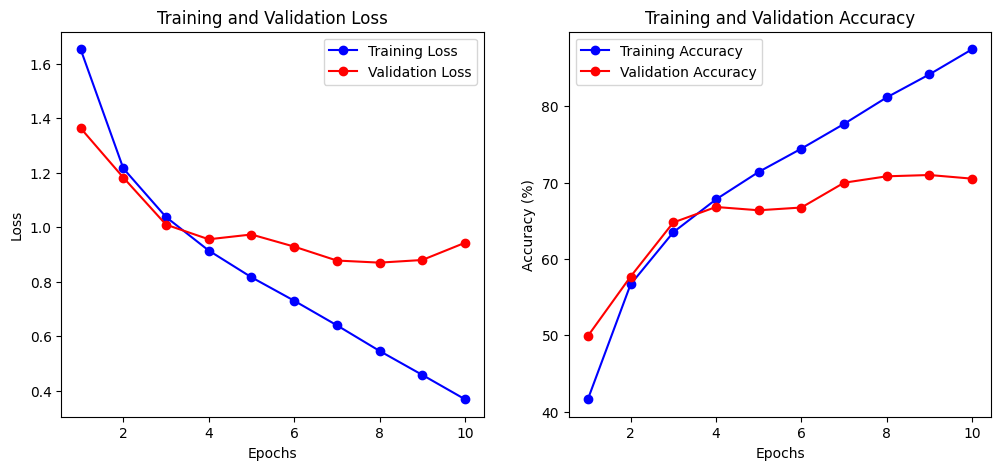

In [ ]:
# 訓練模型並獲取損失與準確率
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(epochs=10)#epochs最多可以調整到15

# 繪製圖表
plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)

6.經過您改進的方法後,模型在測試集的Accuracy達到73.9%或以上(10分)

In [ ]:
# 測試模型
test_model()

Accuracy on the 10000 test images: 70.90%
